In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/cmbitz/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2020 Cecilia Bitz

GNU General Public License v3.0

Original code by Nic Wayand
Revised by Cecilia Bitz

'''

'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')


from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
# General plotting settings
#sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1., rc={"lines.linewidth": 2.5})

In [3]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi'
metric1 = 'extent'

E = ed.EsioData.load()

In [38]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00
# a model must have init_dates made since SDshort to be in the S2S plot
# and since SDlong to be in the S2Y plot and must have at least 3 months 
# these can be fairly generous since we only take data from the last week of any model
SDshort = cd - datetime.timedelta(days=21)  # limit to init_times from last 3 weeks (later we take just the last week's worth)
SDlong = cd - datetime.timedelta(days=60)  # limit to init_times from last 60 days (later we take just the last week's worth)

print(SDshort, SDlong)

2020-02-08 00:00:00 2019-12-31 00:00:00


In [39]:
def AdjustPanArctic(tmp):
    tmp1=tmp.sel(nregions=slice(2,15))
    tmp2=-tmp.sel(nregions=5)-tmp.sel(nregions=14)+tmp.sel(nregions=99)
    tmp=xr.concat([tmp2, tmp1], 'nregions')
    return tmp

In [107]:
#############################################################
# Load in Obs and Benchmark Data
#############################################################

# Load obs already aggregated by region
import timeit
ds_obs = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly_agg/*.nc', concat_dim='time')
ds_obs = ds_obs.Extent
# use smoothed obs to compute damped anom
# 10 days is assumed but would be better to embed this smoothing window in alpha
# and then use it here
ds_obs_smooth = ds_obs.rolling(time=10, min_periods=1, center=True).mean()

# Load trend extrapolated aggregated by region, these are also computed after smoothing

ds_climo = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'_yearly_agg_climatology/*.nc', concat_dim='time')
ds_climo = ds_climo.ClimoTrendExtent
print(ds_climo)

ds_climo = ds_climo.where(ds_climo>0, other=0)

# Load alphas (damping coef)
Y_Start = 1990
Y_End = 2017
file_in = os.path.join(E.obs_dir, 'NSIDC_0079','alpha_agg', str(Y_Start)+'_'+str(Y_End)+'_Alpha.nc')

alpha = xr.open_mfdataset(file_in, parallel=True)
alpha = alpha.alpha

ds_obs=AdjustPanArctic(ds_obs)
ds_obs_smooth=AdjustPanArctic(ds_obs_smooth)
ds_climo=AdjustPanArctic(ds_climo)

# use last week of obs as predictor in damped anomaly benchmarks
anom = ds_obs_smooth - ds_climo
lastdate=ds_obs.time[-1].values
weekago=ds_obs.time[-1].values-np.timedelta64(7, 'D')
anom = anom.where(ds_climo.time>weekago, drop=True) 

# compute doy for anom dataset
DOY = [x.timetuple().tm_yday for x in pd.to_datetime(anom.time.values)]
cc = 'k'
for cit in np.append(0,np.arange(29, len(DOY)-1, 30)):
    print('get alpha for init_time of ',cit)
    alp=alpha.sel(init_time=DOY[cit])
    # add 1 for fore_time = 0
    alp_zero = alp[0]  # begin by stealing part of another dataarray
    alp_zero = alp_zero.expand_dims('fore_time')
    alp_zero.fore_time[0] = 0
    alp_zero.load()
    alp_zero[0] = 1.0
    alp = xr.concat([alp_zero,alp],dim='fore_time')

    damped = anom.isel(time=cit).values*alp
    damped.name = 'DampedAnom'
    tmp = anom['time'].isel(time=cit).values  # +np.timedelta64(5,'D')
    damptimes = pd.to_datetime( damped.fore_time.values, unit='D', origin = tmp)  
    damped.coords['time'] = xr.DataArray(damptimes, dims='fore_time', coords={'fore_time':damped.fore_time})
    damped = damped.swap_dims({'fore_time':'time'})
    #print('damped ',damped)
    damped = damped + ds_climo
    damped = damped.where(damped>0, other=0)
    #damped.plot(ax=ax1, color=cc, linewidth=2)

<xarray.DataArray 'ClimoTrendExtent' (time: 1519, nregions: 15)>
dask.array<shape=(1519, 15), dtype=float64, chunksize=(365, 15)>
Coordinates:
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object 'panArctic' ... 'Central Arctic'
  * time          (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2021-02-27
get alpha for init_time of  0


In [80]:
print(ds_obs.region_names.values)

# some of the models have long lead times, put them in their own panel
longleadtimes=['gfdlsipn','ukmetofficesipn', 'ecmwfsipn', 'meteofrsipn']
maxleadtime=200 # max number of forecast lead times to get

models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if x not in ['dampedAnomalyTrend','piomas', 'MME', 'MME_NEW']] # remove some models
models_2_plot = [x for x in models_2_plot if x not in ['ukmetofficesipn']] # remove some models
models_2_plot = np.append(models_2_plot, 'ukmetofficesipn') # put this at end so it is 'on top' of the other models
print(models_2_plot)

['panArctic' 'Sea of Okhotsk' 'Bering' 'Hudson Bay' 'St John' 'Baffin Bay'
 'East Greenland Sea' 'Barents Sea' 'Kara Sea' 'Laptev Sea'
 'East Siberian Sea' 'Chukchi Sea' 'Beaufort Sea' 'Canadian Islands'
 'Central Arctic']
['gfdlsipn' 'yopp' 'ecmwfsipn' 'meteofrsipn' 'bom' 'cma' 'ecmwf' 'hcmr'
 'isaccnr' 'jma' 'metreofr' 'ukmo' 'eccc' 'kma' 'ncep' 'usnavysipn'
 'usnavyncep' 'rasmesrl' 'noaasipn' 'noaasipn_ext' 'usnavygofs'
 'modcansipns_3' 'modcansipns_4' 'uclsipn' 'szapirosipn' 'awispin'
 'nicosipn' 'fgoalssipn' 'ukmetofficesipn']


In [81]:
cdate = datetime.datetime.now()

# adjust colors to my liking
E.model['usnavygofs']['model_label']='NRL-GOFS'
#print(E.model_color)
#import matplotlib.colors as clr
E.model_color['usnavygofs']='tab:olive'
E.model_color['usnavyncep']='tab:olive'
E.model_color['ncep']='blue'

E.model_linestyle['usnavyncep']='-'
E.model_linestyle['ncep']='-'

E.model_linestyle['ecmwf']='-'
E.model_linestyle['ecmwfsipn']='-'

E.model_color['ecmwf']='darkred'
E.model_color['ecmwfsipn']='darkred'

E.model_color['ecmwf']='darkred'
E.model_color['ecmwfsipn']='darkred'

E.model_color['metreofr']='chocolate'
E.model_color['ukmo']='teal'
E.model_color['ukmetofficesipn']=E.model_color['ukmo']
E.model_color['metreofr']=E.model_color['meteofrsipn']

E.model_linestyle['ukmo']='--'
E.model_linestyle['ukmetofficesipn']='--'
E.model_linestyle['metreofr']='-'
E.model_linestyle['meteofrsipn']='-'

E.model_linestyle['yopp']='-'
E.model_color['fgoalssipn']='darkblue'

In [82]:
# preload the files with one day each per file to speed up
cmod='usnavygofs'
model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')
files = glob.glob(model_forecast)
ds_usnavygofs = xr.open_mfdataset(model_forecast, concat_dim='init_time').load()
cmod='yopp'
model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')
files = glob.glob(model_forecast)
ds_yopp = xr.open_mfdataset(model_forecast, concat_dim='init_time').load()
cmod='fgoalssipn'
model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')
files = glob.glob(model_forecast)
ds_fgoalssipn = xr.open_mfdataset(model_forecast, concat_dim='init_time').load()

# Plot Raw extents and only models that predict sea ice

In [ ]:
# plotting all ensemble members but averaging over last week of data if mode
# has more than monthly init_times

In [71]:
def AggLastNDAYS(ds_model,NDAYS=7):
    #print('ds_model   ',ds_model)
    lastdate=ds_model.init_time[-1].values
    weekago=ds_model.init_time[-1].values-np.timedelta64(NDAYS, 'D')
    #print(weekago,lastdate)
    tmp=ds_model.sel(init_time=slice(weekago,lastdate)) # gets init_times from these dates inclusive
    init_slice=tmp.init_time.values
    if (len(init_slice)>1): # more than one init time so average
        #print(init_slice)
        dt = (init_slice[-1]-init_slice[0])/2  # time range in nanosec
        midptdate = init_slice[0]+np.timedelta64(dt) # the middle of the init_times 

        da_agg =  tmp.mean(dim='init_time')
        da_agg.coords['init_time'] = midptdate # the middle of the init_times 

    else:
        da_agg = ds_model.isel(init_time=-1)

    da_agg = da_agg.expand_dims('init_time')
    #print(da_agg)

    return da_agg

Building plot for region  Pan-Arctic Minus Canadian Islands and St John
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  ukmo 11
2020-02-16T00:00:00.000000000 2020-02-23T00:00:00.000000000
  Working on model  kma 13
2020-02-21T00:00:00.000000000 2020-02-28T00:00:00.000000000
  Working on model  ncep 14
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  usnavysipn 15
  Working on model  usnavyncep 16
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  noaasipn 18
  Working on model  n

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_PanArctic_extent_forecast_raw_predicted.png
Building plot for region  Sea of Okhotsk
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.0000

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Sea_of_Okhotsk_extent_forecast_raw_predicted.png
Building plot for region  Bering
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.0000000

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Bering_extent_forecast_raw_predicted.png
Building plot for region  Hudson Bay
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000000000 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Hudson_Bay_extent_forecast_raw_predicted.png
Building plot for region  St John
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_St_John_extent_forecast_raw_predicted.png
Building plot for region  Baffin Bay
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Baffin_Bay_extent_forecast_raw_predicted.png
Building plot for region  East Greenland Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:0

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_East_Greenland_Sea_extent_forecast_raw_predicted.png
Building plot for region  Barents Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Barents_Sea_extent_forecast_raw_predicted.png
Building plot for region  Kara Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.0000000

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Kara_Sea_extent_forecast_raw_predicted.png
Building plot for region  Laptev Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.00000000

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Laptev_Sea_extent_forecast_raw_predicted.png
Building plot for region  East Siberian Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_East_Siberian_Sea_extent_forecast_raw_predicted.png
Building plot for region  Chukchi Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:0

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Chukchi_Sea_extent_forecast_raw_predicted.png
Building plot for region  Beaufort Sea
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:00.000

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Beaufort_Sea_extent_forecast_raw_predicted.png
Building plot for region  Canadian Islands
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00:0

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Canadian_Islands_extent_forecast_raw_predicted.png
Building plot for region  Central Arctic
  Working on model  gfdlsipn 0
  Working on model  yopp 1
2020-02-18T12:00:00.000000000 2020-02-25T12:00:00.000000000
  Working on model  ecmwfsipn 2
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  meteofrsipn 3
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
  Working on model  ecmwf 6
2020-02-20T00:00:00.000000000 2020-02-27T00:00:00.000000000
  Working on model  metreofr 10
2020-02-20T00:00

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


  Working on model  modcansipns_4 22
  Working on model  uclsipn 23
  Working on model  szapirosipn 24
  Working on model  awispin 25
  Working on model  nicosipn 26
  Working on model  fgoalssipn 27
2020-02-11T00:00:00.000000000 2020-02-18T00:00:00.000000000
  Working on model  ukmetofficesipn 28
2020-01-25T00:00:00.000000000 2020-02-01T00:00:00.000000000
saved figure  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/regional_timeseries/Region_Central_Arctic_extent_forecast_raw_predicted.png


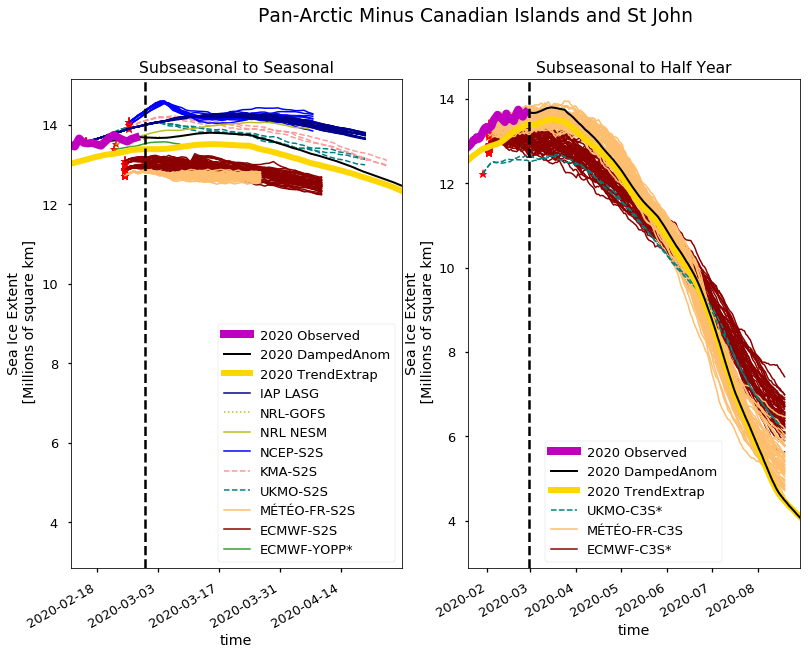

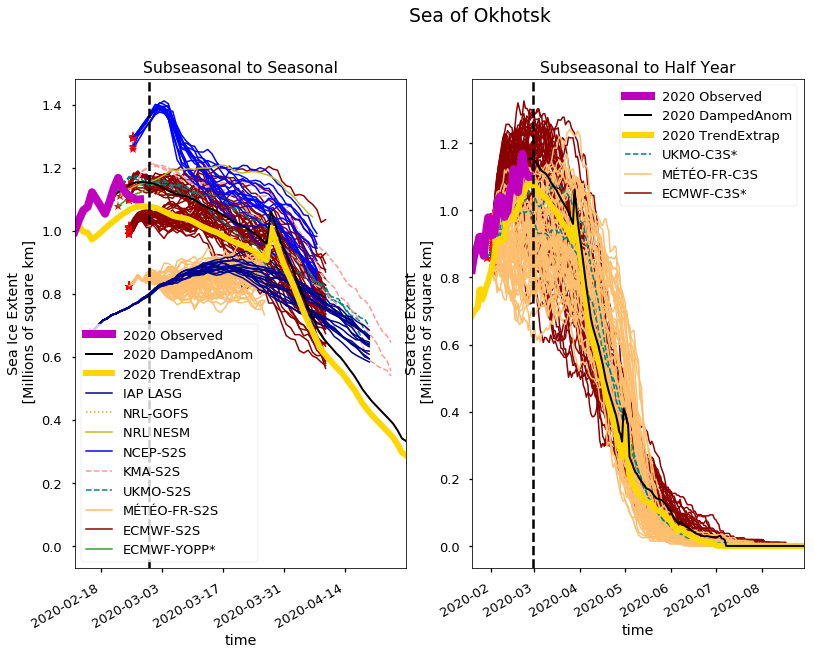

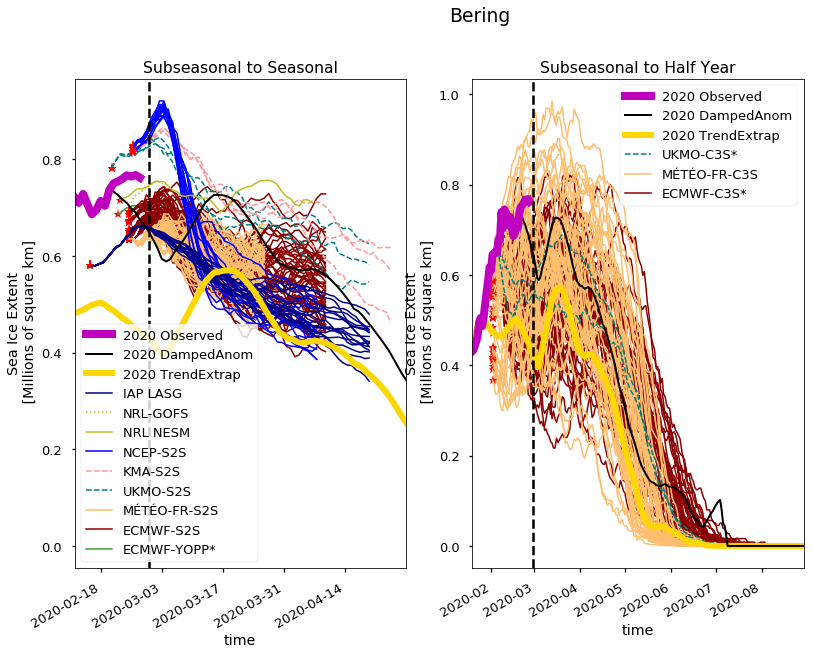

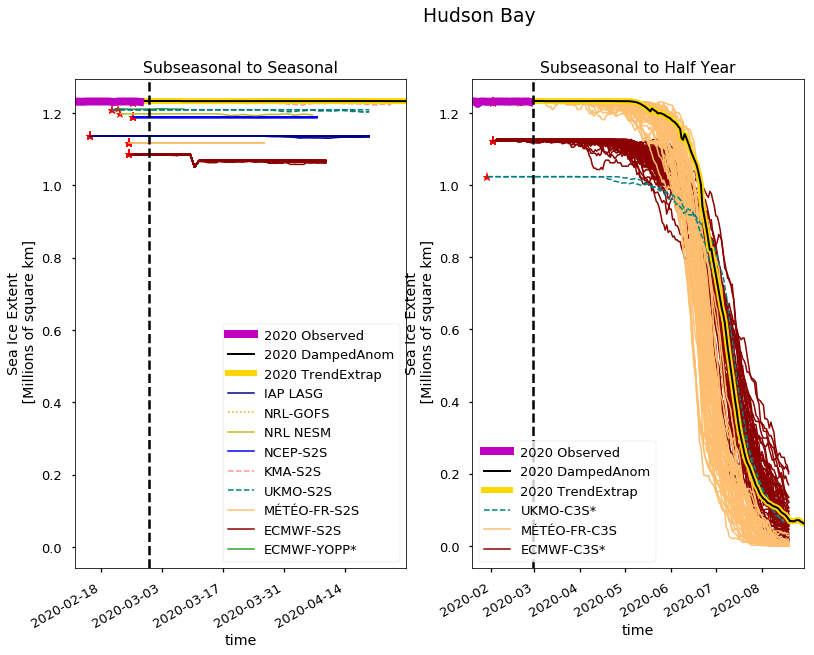

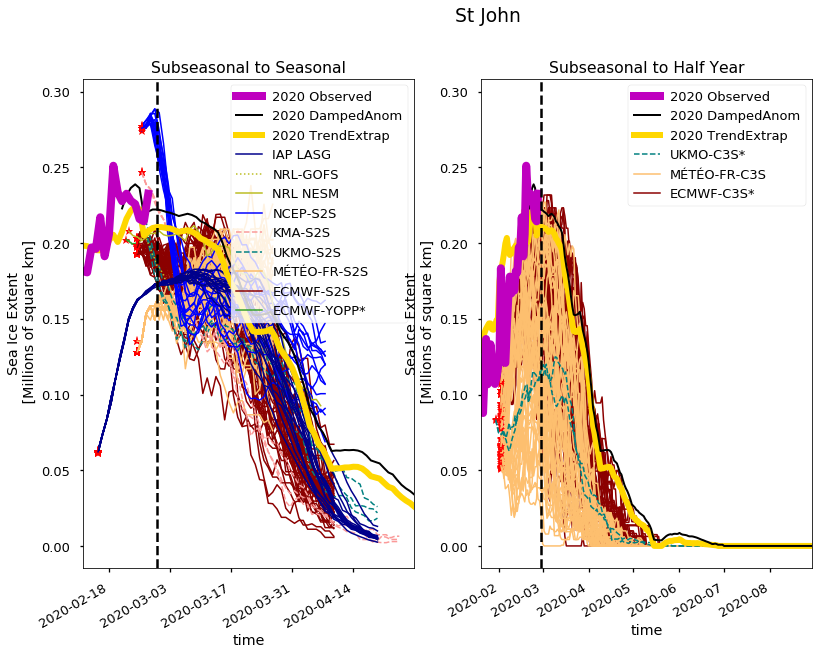

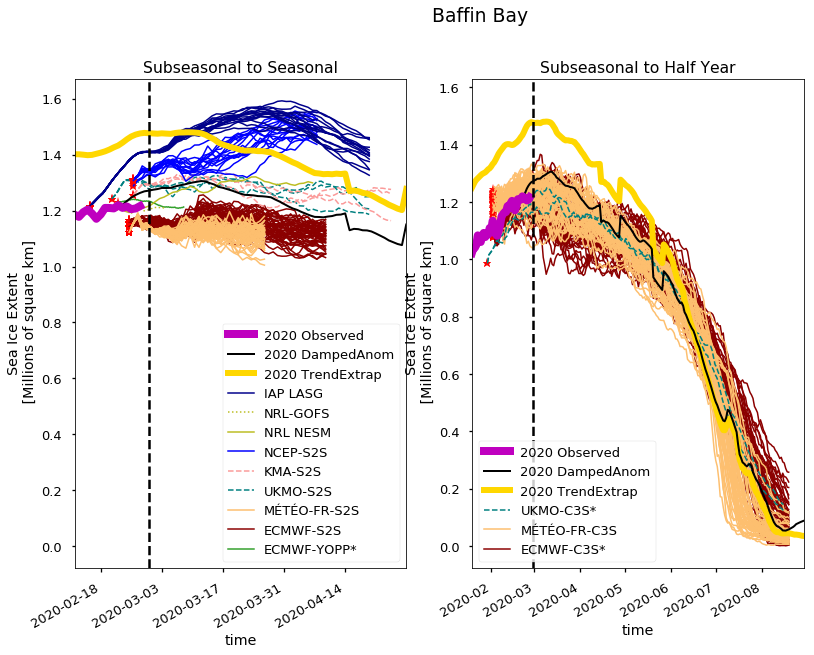

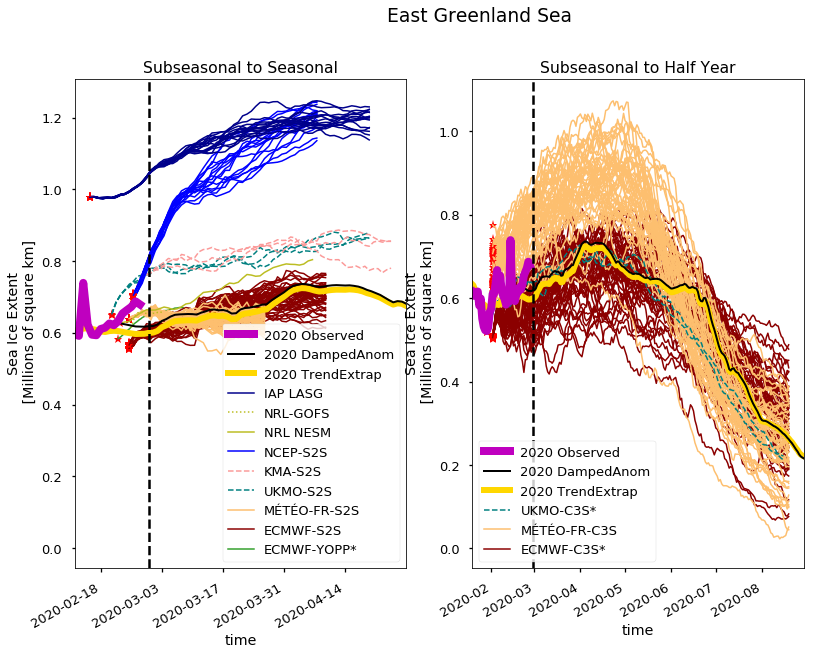

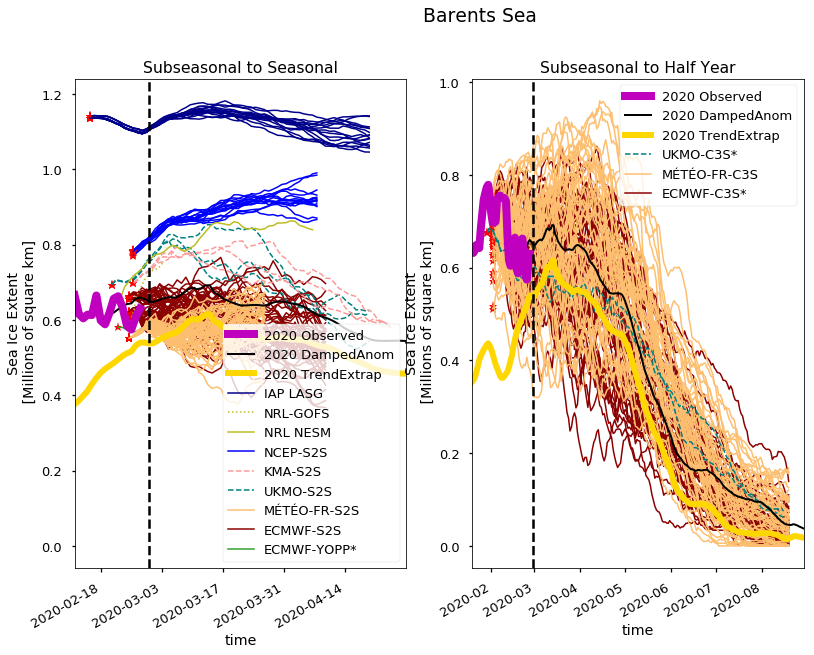

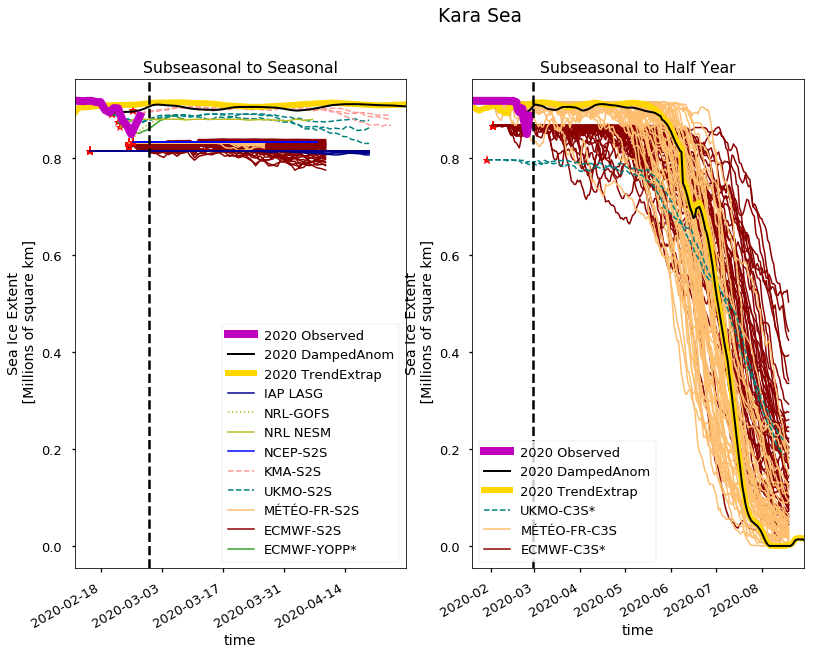

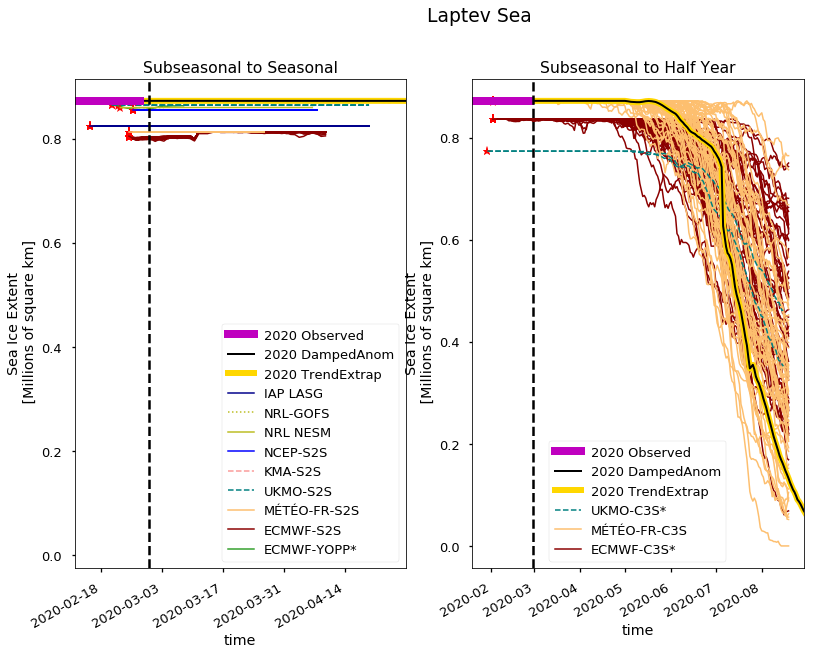

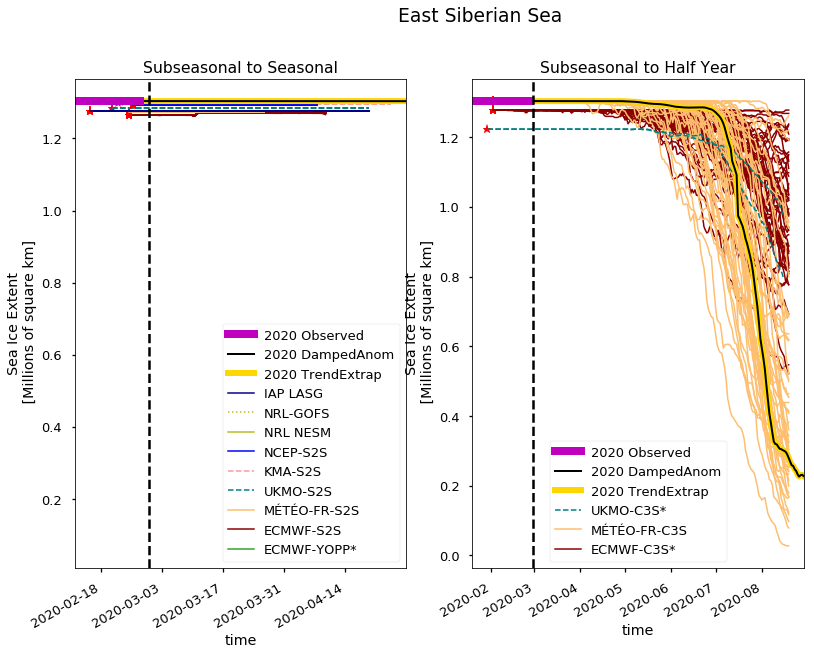

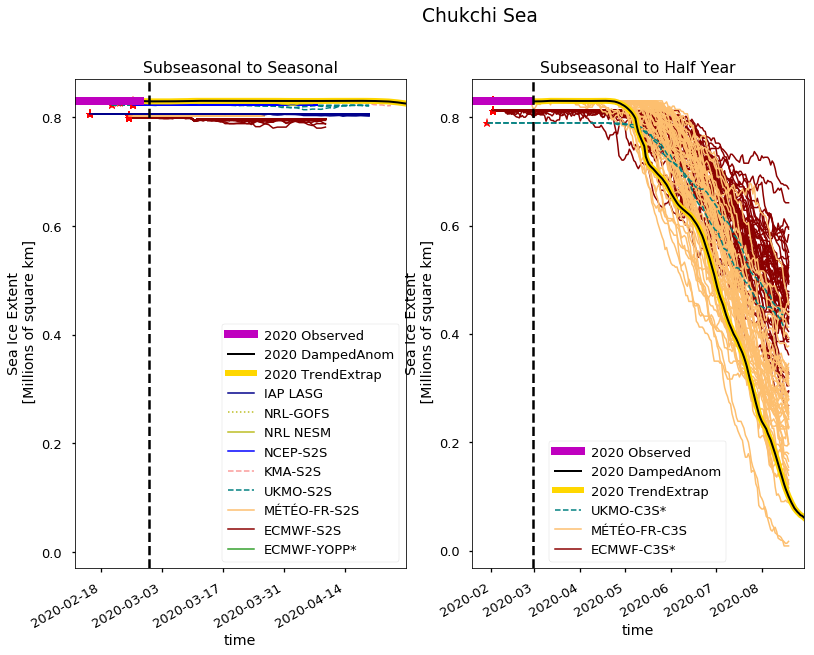

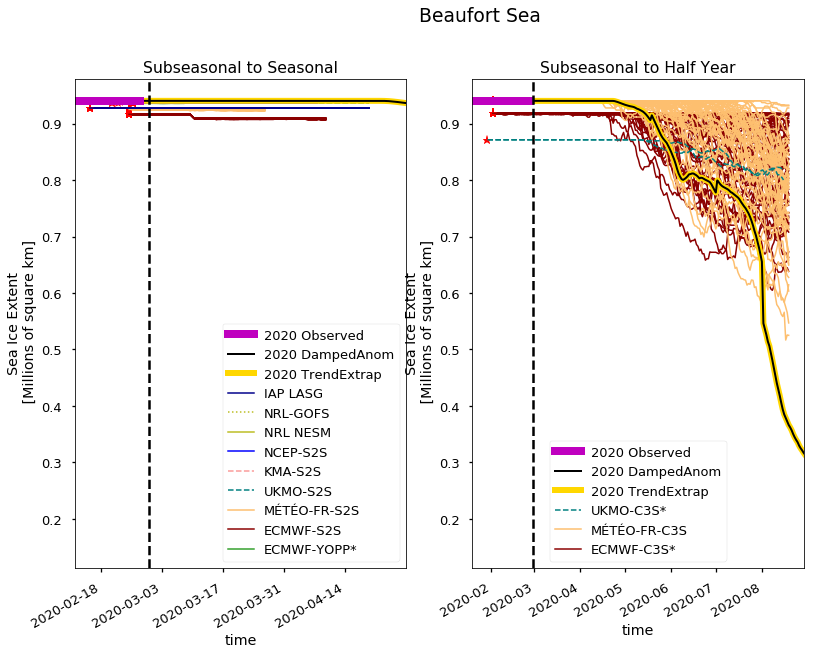

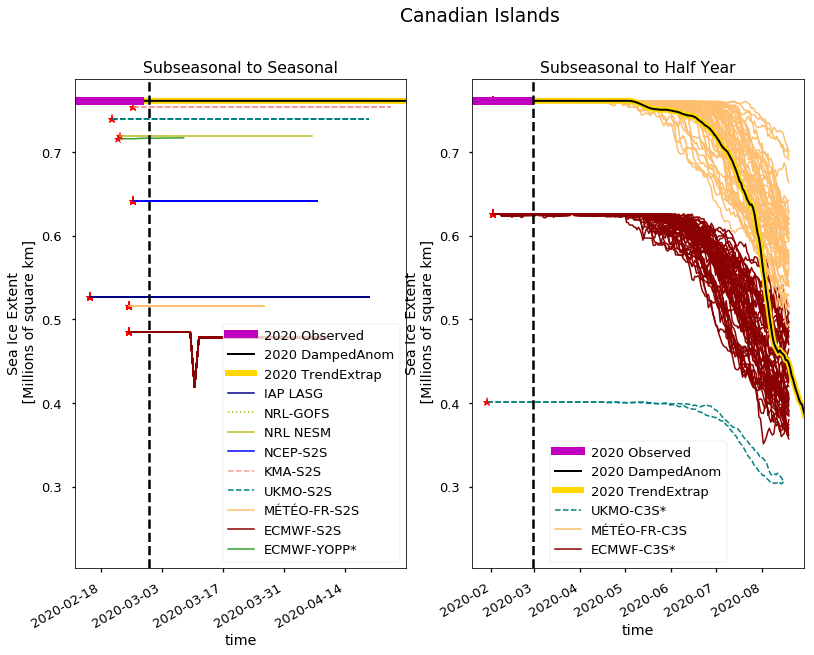

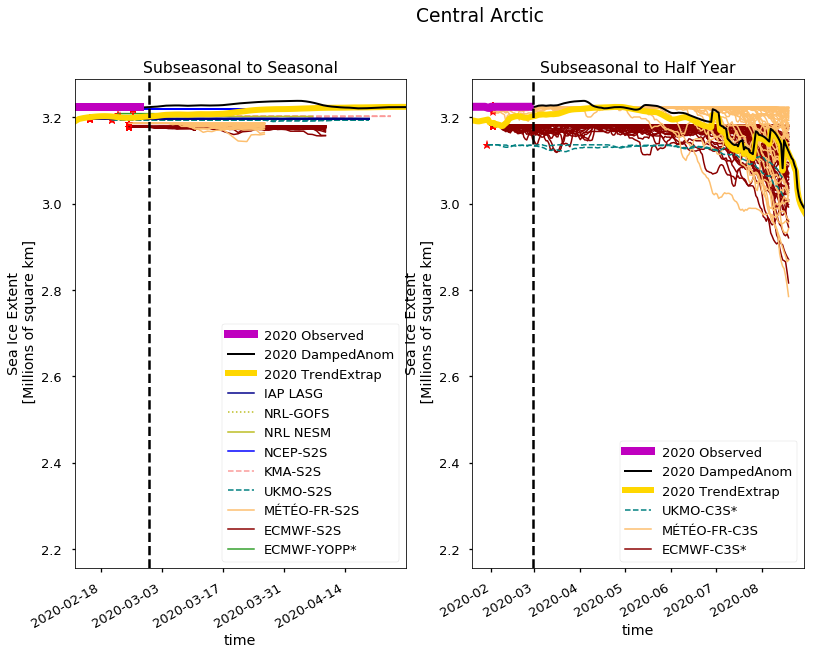

In [109]:
for cvar in variables:
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "regional_timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

# For each region
    for cR in ds_obs.nregions.values:
#    for cR in [9]: # ds_obs.region_names.values   

        cR_name = ds_obs.region_names.sel(nregions=cR).item(0)
        if (cR==99):
            cR_name = 'Pan-Arctic Minus Canadian Islands and St John'

        print('Building plot for region ',cR_name)
        
        f = plt.figure(figsize=(15,10)) # New Plot
        taxi = plt.subplot(121) 
        ax2 = plt.subplot(122) 

        for (i, cmod) in enumerate(models_2_plot):
#        for (i, cmod) in enumerate(['ecmwf','ecmwfsipn']):
#        for (i, cmod) in enumerate(['ukmo','ukmetofficesipn']):

            if not E.icePredicted[cmod]:
                continue
            if ((cmod=='rasmesrl') & (cR in [99, 2, 3, 4, 5, 6, 7, 14])):  # CAFS cuts off these
                continue
            if ((cmod=='awispin') & (cR in [99, 2, 4, 5])):  # CAFS cuts off these
                continue

            print('  Working on model ',cmod,i)
            if cmod == 'usnavygofs':
                ds_model = ds_usnavygofs
            elif cmod == 'yopp':
                ds_model=ds_yopp
            elif cmod =='fgoalssipn':
                ds_model=ds_fgoalssipn
            else:
                model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')
                files = glob.glob(model_forecast) # Check we have files 
                if not files:
                    continue # Skip this model
                ds_model = xr.open_mfdataset(model_forecast, concat_dim='init_time')
                
            ds_model = ds_model.isel(fore_time=slice(0,maxleadtime)).Extent
            if (cR==99):
                ds_model = ds_model.sel(nregions=cR)-ds_model.sel(nregions=5)-ds_model.sel(nregions=14)
            else:
                ds_model = ds_model.sel(nregions=cR)

            if cmod in longleadtimes:  # just consider long records for right panel
                init_start_date_long = np.datetime64(SDlong) # limit to init_times since this date
                ds_model_long = ds_model.where(ds_model.init_time>= init_start_date_long, drop=True)
                #print('ds_model_long   ',ds_model_long)
                if (len(ds_model_long.init_time)>0): 
                    ds_model_long = AggLastNDAYS(ds_model_long)
                    #print('data to plot ',ds_model_long)
                    ice_plot.plot_reforecast(ds=ds_model_long, axin=ax2, 
                                         labelin=E.model[cmod]['model_label'],
                                         color=E.model_color[cmod], marker=None,
                                         linestyle=E.model_linestyle[cmod],
                                         no_init_label=True)

            # all models are considered for left panel (S2S)
            init_start_date = np.datetime64(SDshort) # limit to init_times in last since this date
            ds_model = ds_model.where(ds_model.init_time>= init_start_date, drop=True)
            #print('ds_model_short ',ds_model)

            if (len(ds_model.init_time)==0):  # nothing to plot
                #print("For S2S plot: Skipping model ",cmod," with no initial times ", ds_model)
                continue

            ds_model = AggLastNDAYS(ds_model)
            #print('data to plot ',ds_model)
            ice_plot.plot_reforecast(ds=ds_model, axin=taxi, 
                                 labelin=E.model[cmod]['model_label'],
                                 color=E.model_color[cmod], marker=None,
                                 linestyle=E.model_linestyle[cmod],
                                 no_init_label=True)
            
            # Memeory clean up
            ds_model = None  
            ds_model_long = None     

        # add obs and benchmarks to each panel
        for axi in [taxi, ax2]:
            cxlims1 = axi.get_xlim()
            ds_climo.sel(nregions=cR).plot(ax=axi, label=str(cdate.year)+' TrendExtrap', color='gold', linewidth=6)
            damped.sel(nregions=cR).plot(ax=axi, label=str(cdate.year)+' DampedAnom', color=cc, linewidth=2)
            ds_obs.sel(nregions=cR).plot(ax=axi, label=str(cdate.year)+' Observed', color='m', linewidth=8)
            axi.set_ylabel('Sea Ice Extent\n [Millions of square km]')
            axi.set_xlim(cxlims1) # fix x limits
            cylims1 = axi.get_ylim()

            # Plot current date vertical dashed line
            axi.plot([cd, cd], [cylims1[0], cylims1[1]], color='k', linestyle='--')

            handles, labels = axi.get_legend_handles_labels()
            # print(labels)
            axi.legend(handles[::-1], labels[::-1])
            axi.set_ylim(cylims1)
               
        taxi.set_title('Subseasonal to Seasonal')
        ax2.set_title('Subseasonal to Half Year')

        f.suptitle(cR_name)
        f.autofmt_xdate()
        plt.subplots_adjust(right=.8)

        # Save to file
        if (cR==99):
            base_name_out = 'Region_PanArctic_'+metric1+'_'+runType+'_raw_predicted'
        else:
            base_name_out = 'Region_'+cR_name.replace(" ", "_")+'_'+metric1+'_'+runType+'_raw_predicted'
        f_out = os.path.join(fig_dir, base_name_out+'.png')
        f.savefig(f_out,bbox_inches='tight',dpi=200)
        print('saved figure ',f_out)


In [ ]:
# Olde function not read to eliminate, improved routine is below AggLastNDAYS

# nothing in this cell is needed anymore but can't yet part with it

BunchByWeek = True  # average init_times into weekly chunks but leave fore_time daily

# list of models that have month init times, do not bunch these by week
monthly_init_model = ['gfdlsipn','ecmwfsipn', 'ukmetofficesipn', 'meteofrsipn','metreofr','awispin','nicosipn']

def Daily2Weekly(ds_model,init_start_date):

    start_t = datetime.datetime(1950, 1, 1) # datetime.datetime(1950, 1, 1)
    print(ds_model.init_time.values)
    print(ds_model.init_time[-1].values)
    init_slice = np.arange(start_t, ds_model.init_time[-1].values, datetime.timedelta(days=7)).astype('datetime64[ns]')
    print('init_slice 1 ',init_slice)
    print('init start date ',init_start_date)
    init_slice = init_slice[init_slice>=init_start_date] # Select only the inits after init_start_date
    print('init_slice 2 ',init_slice)
    
    if not init_slice:
        print('List is empty')
        return None
    
    da_agg = []
    counter = 0
    for (itweek,it) in enumerate(init_slice):
        #print('---- itweek',itweek, it, len(init_slice))
        if itweek<(len(init_slice)-1):
            thesedates = (ds_model.init_time>=init_slice[itweek]) & (ds_model.init_time<init_slice[itweek+1])
        else:
            thesedates = (ds_model.init_time>=init_slice[itweek]) & (ds_model.init_time<=ds_model.init_time[-1])
        thesedates = ds_model.init_time.where(thesedates, drop=True )
        print('the dates are ', thesedates)
        if (len(thesedates)==0):
            print('no dates in this weekly slice')
            continue
        print('  Start date this period :',thesedates[0])
        halfwidth = (thesedates[-1]-thesedates[0])*0.5
        itweekdate = thesedates[0] + halfwidth
        itweekdate.rename({'init_time':'itweek'})
        print('  Middle of the period date: ', itweekdate)

        da_itw =  ds_model.where(thesedates, drop=True ).mean(dim='init_time')
        da_itw.coords['itweek'] = itweek
        da_itw.coords['itweekdate'] = itweekdate

        print(da_itw)
        # Store in list
        da_agg.append(da_itw)
        counter = counter + 1

    if counter>1:
        da_agg = xr.concat(da_agg, dim='itweek')
        da_agg=da_agg.drop('init_time')
        da_agg.coords['init_time'] = da_agg.itweekdate
        da_agg=da_agg.swap_dims({'itweek':'init_time'}) # drat the plot routine requires init_time as dim                

    else:
        da_agg = da_agg[0]
        da_agg=da_agg.drop('init_time')
        da_agg.coords['init_time'] = da_agg.itweekdate
        da_agg = da_agg.expand_dims('init_time')

    #print('\n\nda_agg\n',da_agg)

    ds_model = da_agg
    da_agg = None
    return ds_model